# Predicting Housing Prices

authors: Scott Breitbach, Pushkar Chougule & Rachel Nelson

class: DSC630-T301 Predictive Analytics (2221-1)

### Load and Review Raw Data

In [525]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [526]:
# Load data sets
dfTrain = pd.read_csv("train.csv")
dfTest = pd.read_csv("test.csv")

# Get # of rows and columns of data set
print("Shape of training data set:", dfTrain.shape)
print("Shape of testing data set: ", dfTest.shape)

Shape of training data set: (1460, 81)
Shape of testing data set:  (1459, 80)


In [527]:
# Combine data sets for Data Analysis
dfBoth = pd.concat([dfTrain, dfTest], keys=['train', 'test'], names=['dataSet', 'index'])
print("Shape of combined data set:", dfBoth.shape)

Shape of combined data set: (2919, 81)


In [528]:
# Looking at data and get summary statistics
print(dfBoth.head(5))
print(dfBoth.describe())

               Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
dataSet index                                                               
train   0       1          60       RL         65.0     8450   Pave   NaN   
        1       2          20       RL         80.0     9600   Pave   NaN   
        2       3          60       RL         68.0    11250   Pave   NaN   
        3       4          70       RL         60.0     9550   Pave   NaN   
        4       5          60       RL         84.0    14260   Pave   NaN   

              LotShape LandContour Utilities  ... PoolArea PoolQC Fence  \
dataSet index                                 ...                         
train   0          Reg         Lvl    AllPub  ...        0    NaN   NaN   
        1          Reg         Lvl    AllPub  ...        0    NaN   NaN   
        2          IR1         Lvl    AllPub  ...        0    NaN   NaN   
        3          IR1         Lvl    AllPub  ...        0    NaN   NaN   
        4 

### Data Cleansing and Prep
##### Reviewing Null Values

In [529]:
# Get a sorted list of the numbers of Null values
missingVals = dfBoth.isnull().sum()
missingVals = missingVals[missingVals > 0]
missingVals.sort_values()

Electrical         1
GarageArea         1
GarageCars         1
Exterior1st        1
Exterior2nd        1
KitchenQual        1
SaleType           1
TotalBsmtSF        1
BsmtFinSF1         1
BsmtUnfSF          1
BsmtFinSF2         1
Utilities          2
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
MSZoning           4
MasVnrArea        23
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtExposure      82
BsmtCond          82
GarageType       157
GarageCond       159
GarageQual       159
GarageFinish     159
GarageYrBlt      159
LotFrontage      486
FireplaceQu     1420
SalePrice       1459
Fence           2348
Alley           2721
MiscFeature     2814
PoolQC          2909
dtype: int64

<AxesSubplot:title={'center':'Missing Values'}>

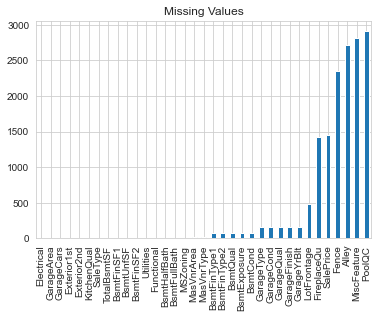

In [530]:
# Create Chart of missing values
missingVals.sort_values(inplace=True)
plt.title('Missing Values')
missingVals.plot.bar()

##### I was tempted to just remove any rows that have Null values in any of the columns with 5 or fewer Null values (Electrical through MSZoning), but I think we can make sense of some of them. For instance, the NaNs in `GarageArea` and `GarageCars` were probably just no garage and can reasonably be replaced with a zero.

In [531]:
# Replace null values with zero for null garage values
# Making assumption that null values means there is no garage
dfBoth.GarageArea.fillna(0, inplace=True)
dfBoth.GarageCars.fillna(0, inplace=True)

# Get the counts for each garage size (in cars)
dfBoth.GarageCars.value_counts()

2.0    1594
1.0     776
3.0     374
0.0     158
4.0      16
5.0       1
Name: GarageCars, dtype: int64

##### Note the 157 zeroes (158 now) indicating no garage. The other Garage-type variables all have 157-159 Null values. We can set up a rule to change those NaNs to `None` for rows where `GarageCars == 0`. 

In [532]:
# Conditionally replace null values with 'None'
garageVars = ["GarageType", "GarageCond", "GarageQual", 
              "GarageFinish", "GarageYrBlt"]
for i in garageVars:
    dfBoth.loc[dfBoth['GarageCars'] == 0.0, i] = 'None'

##### Similarly, Null values in Basement-related variables likely indicate no basement and can also be replaced with a zero.

In [533]:
# Replace null values with zero
bsmtVars = ["TotalBsmtSF", "BsmtFinSF1", "BsmtFinSF2", 
            "BsmtUnfSF", "BsmtHalfBath", "BsmtFullBath"]
for i in bsmtVars:
    dfBoth[i].fillna(0, inplace=True)

In [534]:
# Conditionally replace null values with 'None'
garageVars = ["BsmtFinType1", "BsmtFinType2", "BsmtQual", 
              "BsmtCond", "BsmtExposure"]
for i in garageVars:
    dfBoth.loc[dfBoth['TotalBsmtSF'] == 0.0, i] = 'None'

In [535]:
# Get a sorted list of the numbers of Null values
missingVals = dfBoth.isnull().sum()
missingVals = missingVals[missingVals > 0]
missingVals.sort_values()

Electrical         1
GarageCond         1
GarageQual         1
Exterior1st        1
Exterior2nd        1
GarageFinish       1
GarageYrBlt        1
BsmtFinType2       1
SaleType           1
KitchenQual        1
Utilities          2
BsmtQual           2
Functional         2
BsmtCond           3
BsmtExposure       3
MSZoning           4
MasVnrArea        23
MasVnrType        24
LotFrontage      486
FireplaceQu     1420
SalePrice       1459
Fence           2348
Alley           2721
MiscFeature     2814
PoolQC          2909
dtype: int64

##### There are still Garage-related variables coming up null. I checked and they're all the same entry (test set, index 666). I suspect there is no garage and the number of cars for this entry (1.0) was mis-coded. We could delete this entry or set it up as no garage.

In [536]:
dfBoth[dfBoth['GarageCond'].isnull()]

,,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
dataSet,index,,,,,,,,,,,,,,,,,,,,,
test,666,2127,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,1000,9,2008,WD,Normal,NaN


##### I suspect something similar is happening with the Basement variables.

In [537]:
dfBoth[dfBoth['BsmtQual'].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
dataSet index                                                                 
test    757    2218          70  C (all)         60.0     5280   Pave   NaN   
        758    2219          50  C (all)         52.0     5150   Pave   NaN   

              LotShape LandContour Utilities  ... PoolArea PoolQC Fence  \
dataSet index                                 ...                         
test    757        Reg         Lvl    AllPub  ...        0    NaN   NaN   
        758        Reg         Lvl    AllPub  ...        0    NaN   NaN   

              MiscFeature MiscVal MoSold YrSold  SaleType  SaleCondition  \
dataSet index                                                              
test    757           NaN       0      7   2008        WD         Normal   
        758           NaN       0      5   2008        WD         Normal   

               SalePrice  
dataSet index             
test    757          NaN  
        758          NaN  

[2 rows x 81 columns]

In [538]:
dfBoth[dfBoth['BsmtCond'].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
dataSet index                                                                 
test    580    2041          20       RL        103.0    16280   Pave   NaN   
        725    2186          20       RL         65.0     6500   Pave   NaN   
        1064   2525          80       RL         72.0     9720   Pave   NaN   

              LotShape LandContour Utilities  ... PoolArea PoolQC  Fence  \
dataSet index                                 ...                          
test    580        Reg         Lvl    AllPub  ...        0    NaN   GdWo   
        725        Reg         Lvl    AllPub  ...        0    NaN    NaN   
        1064       Reg         Lvl    AllPub  ...        0    NaN  MnPrv   

              MiscFeature MiscVal MoSold YrSold  SaleType  SaleCondition  \
dataSet index                                                              
test    580           NaN       0      5   2008        WD         Normal   
        725           NaN       0      5   2008        WD         Normal   
        1064          NaN       0      6   2007        WD         Normal   

               SalePrice  
dataSet index             
test    580          NaN  
        725          NaN  
        1064         NaN  

[3 rows x 81 columns]

In [539]:
dfBoth[dfBoth['BsmtExposure'].isnull()]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
dataSet index                                                                 
train   948     949          60       RL         65.0    14006   Pave   NaN   
test    27     1488          20       RL         73.0     8987   Pave   NaN   
        888    2349          60       FV         81.0    10411   Pave   NaN   

              LotShape LandContour Utilities  ... PoolArea PoolQC Fence  \
dataSet index                                 ...                         
train   948        IR1         Lvl    AllPub  ...        0    NaN   NaN   
test    27         Reg         Lvl    AllPub  ...        0    NaN   NaN   
        888        Reg         Lvl    AllPub  ...        0    NaN   NaN   

              MiscFeature MiscVal MoSold YrSold  SaleType  SaleCondition  \
dataSet index                                                              
train   948           NaN       0      2   2006        WD         Normal   
test    27            NaN       0      5   2010        WD         Normal   
        888           NaN       0      7   2007       New        Partial   

               SalePrice  
dataSet index             
train   948     192500.0  
test    27           NaN  
        888          NaN  

[3 rows x 81 columns]

In [540]:
dfBoth[dfBoth['BsmtFinType2'].isnull()]

,,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
dataSet,index,,,,,,,,,,,,,,,,,,,,,
train,332,333,20,RL,85.0,10655,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,284000.0


##### Nope, it turns out that is not the case with the basements. Each of these will need to be dealt with individually or we could remove them.  
EDIT: This issue is resolved in the steps below.

##### To grab some of the low-hanging fruit, I'll go through the *data_description.txt* file and assign a value to some of the NAs that actually represent something.  
For example, in the **Alley** variable, NA means 'No alley access' so I'll change all NaN's to `'None'`.  
NOTE: Maybe it would be best to do this step first.

In [541]:
# For Alley, NA represents 'No alley access'; replace with 'None'
dfBoth.Alley.fillna('None', inplace=True)

In [542]:
# For BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, & BsmtFinType2,
# NA represents 'No basement'; replace with 'None'
bsmtVars = ["BsmtQual", "BsmtCond", "BsmtExposure", 
            "BsmtFinType1", "BsmtFinType2"]
for i in bsmtVars:
    dfBoth[i].fillna('None', inplace=True)

In [543]:
# For FireplaceQu, NA represents 'No Fireplace'; replace with 'None'
dfBoth.FireplaceQu.fillna('None', inplace=True)

In [544]:
# For GarageType, GarageFinish, GarageQual, & GarageCond,
# NA represents 'No Garage'; replace with 'None'
garageVars = ["GarageType", "GarageFinish", 
              "GarageQual", "GarageCond"]
for i in garageVars:
    dfBoth[i].fillna('None', inplace=True)

In [545]:
# For PoolQC, NA represents 'No Pool'; replace with 'None'
dfBoth.PoolQC.fillna('None', inplace=True)

In [546]:
# For Fence, NA represents 'No Fence'; replace with 'None'
dfBoth.Fence.fillna('None', inplace=True)

In [547]:
# For MiscFeature, NA represents 'None'; replace with 'None'
dfBoth.MiscFeature.fillna('None', inplace=True)

In [548]:
# Get a sorted list of the numbers of Null values
missingVals = dfBoth.isnull().sum()
missingVals = missingVals[missingVals > 0]
missingVals.sort_values()

Exterior1st       1
Exterior2nd       1
Electrical        1
KitchenQual       1
GarageYrBlt       1
SaleType          1
Utilities         2
Functional        2
MSZoning          4
MasVnrArea       23
MasVnrType       24
LotFrontage     486
SalePrice      1459
dtype: int64

##### Many of these remaining should not contain null values (with the exception of SalePrice, which is our Test data).  

In [549]:
print(dfBoth.Exterior1st.value_counts())
print(dfBoth.Exterior2nd.value_counts())

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
CBlock        2
Stone         2
ImStucc       1
Name: Exterior1st, dtype: int64
VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64


##### Looking at these counts, I suspect when there is only one type of exterior that they put the same value for both (since there isn't a NA option for secondary).

In [550]:
print(dfBoth.loc[dfBoth['Exterior1st'].isnull(), 'Exterior2nd'])
print(dfBoth.loc[dfBoth['Exterior1st'].isnull(), 'ExterQual'])
print(dfBoth.loc[dfBoth['Exterior1st'].isnull(), 'ExterCond'])

dataSet  index
test     691      NaN
Name: Exterior2nd, dtype: object
dataSet  index
test     691      TA
Name: ExterQual, dtype: object
dataSet  index
test     691      TA
Name: ExterCond, dtype: object


##### Test data index 691: No listed primary or secondary exterior, but both Quality and Condition are "Average/Typical"

In [551]:
dfBoth[dfBoth['Exterior1st'].isnull()]

,,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
dataSet,index,,,,,,,,,,,,,,,,,,,,,
test,691,2152,30,RL,85.0,19550,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,NaN


##### Impute Remaining Missing values with Mean Column Value

In [552]:
# impute remaining missing values based on average for column, except for saleprice, which is changed to 'None'
dfBoth.SalePrice.fillna('0', inplace=True)
dfBoth = dfBoth.fillna(dfBoth.mean())
dfBoth.to_csv('dfboth.csv',index=False)

In [553]:
print(dfBoth.describe())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  2919.000000  2919.000000  2919.000000    2919.000000  2919.000000   
mean   1460.000000    57.137718    69.305795   10168.114080     6.089072   
std     842.787043    42.517628    21.312345    7886.996359     1.409947   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     730.500000    20.000000    60.000000    7478.000000     5.000000   
50%    1460.000000    50.000000    69.305795    9453.000000     6.000000   
75%    2189.500000    70.000000    78.000000   11570.000000     7.000000   
max    2919.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  2919.000000  2919.000000   2919.000000  2919.000000  2919.000000  ...   
mean      5.564577  1971.312778   1984.264474   102.201312   441.272011  ...   
std       1.113131    30.291442     20.894344   178.626089   455.606014  ..

##### Cleansing categorical data

In [554]:
## removing test set from data since it does not contain the saleprice and we need to look at categorical values
dfTrainC = dfBoth.loc[dfBoth['SalePrice'] != '0']

##### Boxplots of categorical data to see which ones I can remove based on categorical distributions compared to sales price

<AxesSubplot:xlabel='MSZoning', ylabel='SalePrice'>

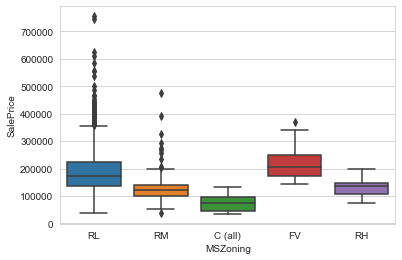

In [555]:
#
sns.set_style("whitegrid")
sns.boxplot(x = 'MSZoning', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='Street', ylabel='SalePrice'>

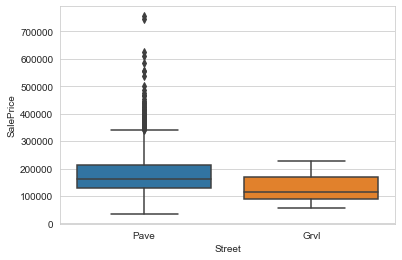

In [556]:
sns.boxplot(x = 'Street', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='Alley', ylabel='SalePrice'>

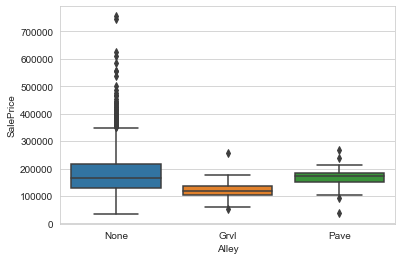

In [557]:
sns.boxplot(x = 'Alley', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='LotShape', ylabel='SalePrice'>

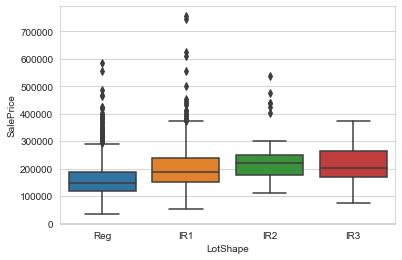

In [558]:
sns.boxplot(x = 'LotShape', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='LandContour', ylabel='SalePrice'>

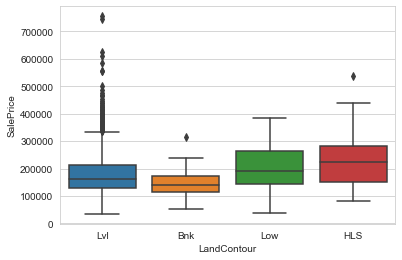

In [559]:
sns.boxplot(x = 'LandContour', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='Utilities', ylabel='SalePrice'>

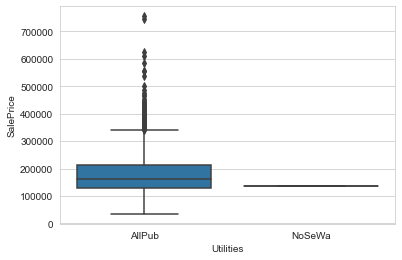

In [560]:
sns.boxplot(x = 'Utilities', y = 'SalePrice', data = dfTrainC)
# will remove this variable

<AxesSubplot:xlabel='LotConfig', ylabel='SalePrice'>

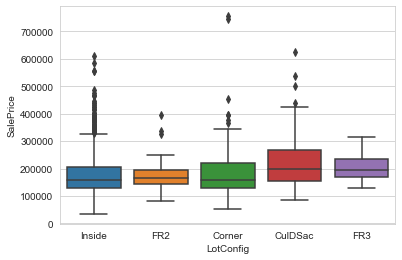

In [561]:
sns.boxplot(x = 'LotConfig', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='LandSlope', ylabel='SalePrice'>

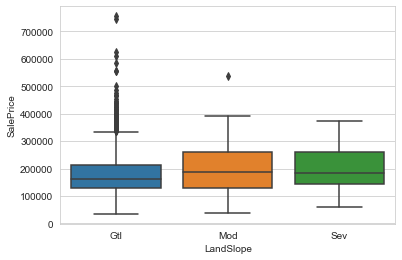

In [562]:
sns.boxplot(x = 'LandSlope', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

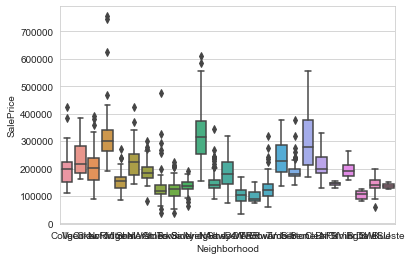

In [563]:
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='Condition1', ylabel='SalePrice'>

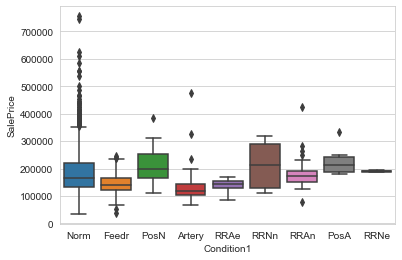

In [564]:
sns.boxplot(x = 'Condition1', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='Condition2', ylabel='SalePrice'>

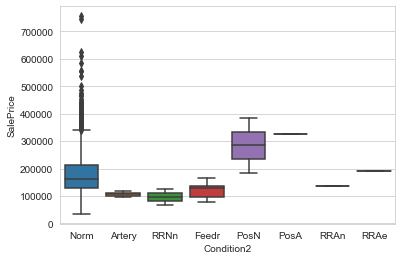

In [565]:
sns.boxplot(x = 'Condition2', y = 'SalePrice', data = dfTrainC)
# will remove this variable

<AxesSubplot:xlabel='BldgType', ylabel='SalePrice'>

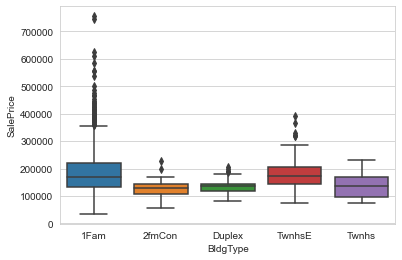

In [566]:
sns.boxplot(x = 'BldgType', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='HouseStyle', ylabel='SalePrice'>

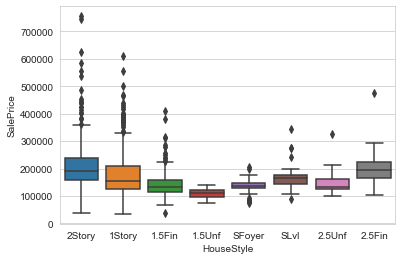

In [567]:
sns.boxplot(x = 'HouseStyle', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='RoofStyle', ylabel='SalePrice'>

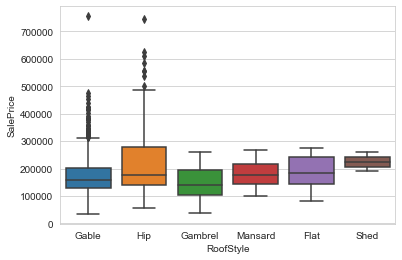

In [568]:
sns.boxplot(x = 'RoofStyle', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='RoofMatl', ylabel='SalePrice'>

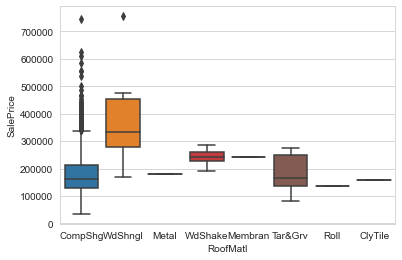

In [569]:
sns.boxplot(x = 'RoofMatl', y = 'SalePrice', data = dfTrainC)
# will remove this variable

<AxesSubplot:xlabel='Exterior1st', ylabel='SalePrice'>

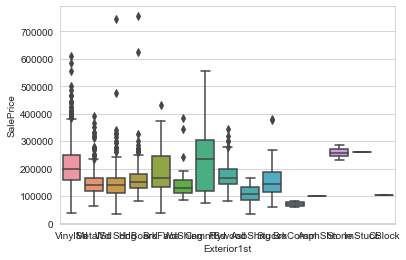

In [570]:
sns.boxplot(x = 'Exterior1st', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='Exterior2nd', ylabel='SalePrice'>

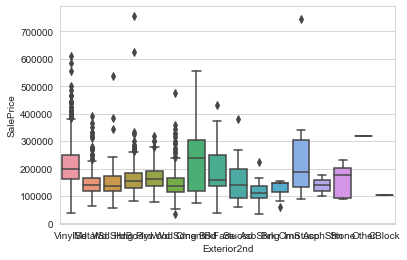

In [571]:
sns.boxplot(x = 'Exterior2nd', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='MasVnrType', ylabel='SalePrice'>

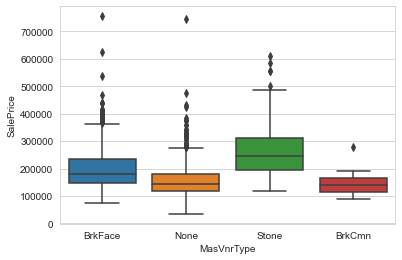

In [572]:
sns.boxplot(x = 'MasVnrType', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='ExterQual', ylabel='SalePrice'>

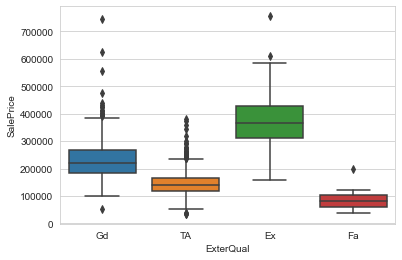

In [573]:
sns.boxplot(x = 'ExterQual', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='ExterCond', ylabel='SalePrice'>

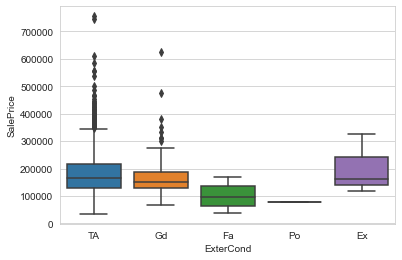

In [574]:
sns.boxplot(x = 'ExterCond', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice'>

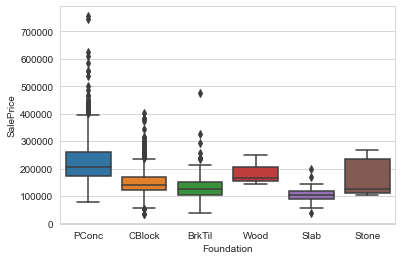

In [575]:
sns.boxplot(x = 'Foundation', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='BsmtQual', ylabel='SalePrice'>

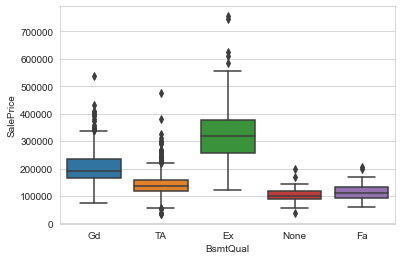

In [576]:
sns.boxplot(x = 'BsmtQual', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='BsmtCond', ylabel='SalePrice'>

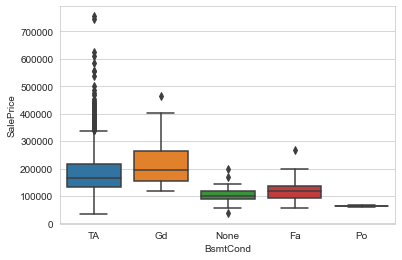

In [577]:
sns.boxplot(x = 'BsmtCond', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='BsmtExposure', ylabel='SalePrice'>

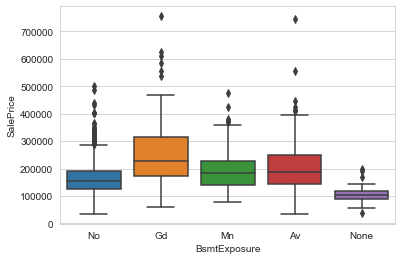

In [578]:
sns.boxplot(x = 'BsmtExposure', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='BsmtFinType1', ylabel='SalePrice'>

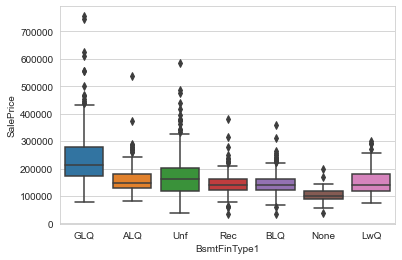

In [579]:
sns.boxplot(x = 'BsmtFinType1', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='BsmtFinType2', ylabel='SalePrice'>

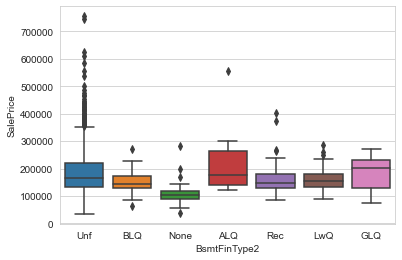

In [580]:
sns.boxplot(x = 'BsmtFinType2', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='Heating', ylabel='SalePrice'>

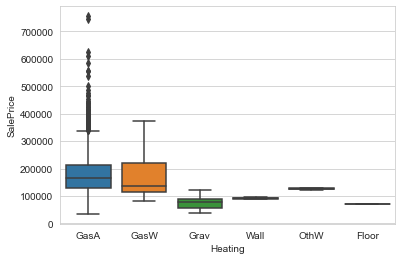

In [581]:
sns.boxplot(x = 'Heating', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

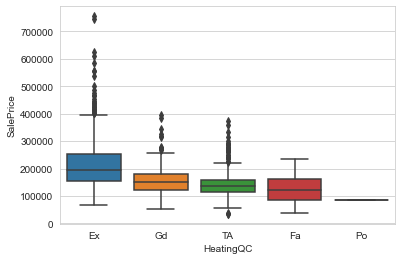

In [582]:
sns.boxplot(x = 'HeatingQC', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='CentralAir', ylabel='SalePrice'>

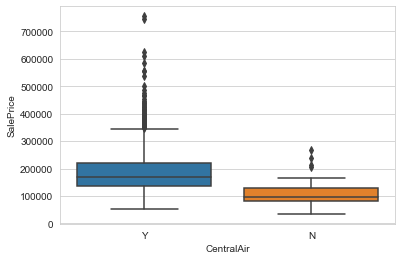

In [583]:
sns.boxplot(x = 'CentralAir', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='Electrical', ylabel='SalePrice'>

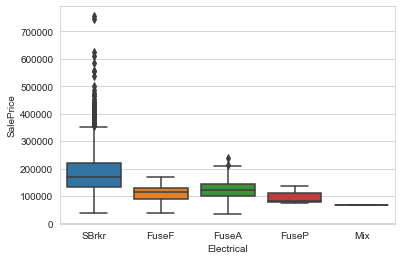

In [584]:
sns.boxplot(x = 'Electrical', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='KitchenQual', ylabel='SalePrice'>

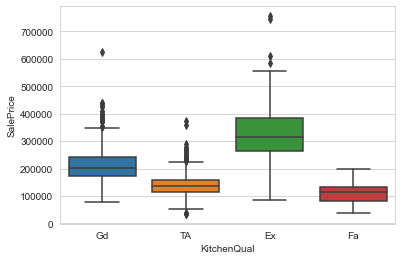

In [585]:
sns.boxplot(x = 'KitchenQual', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='Functional', ylabel='SalePrice'>

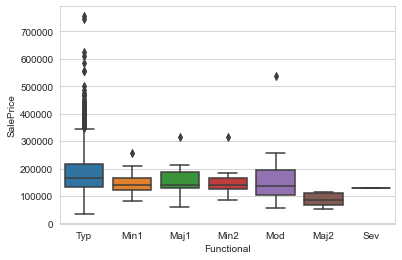

In [586]:
sns.boxplot(x = 'Functional', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='FireplaceQu', ylabel='SalePrice'>

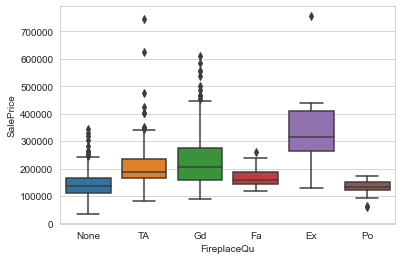

In [587]:
sns.boxplot(x = 'FireplaceQu', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='GarageType', ylabel='SalePrice'>

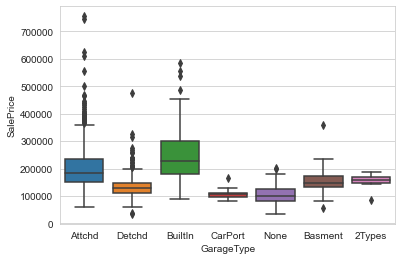

In [588]:
sns.boxplot(x = 'GarageType', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='GarageFinish', ylabel='SalePrice'>

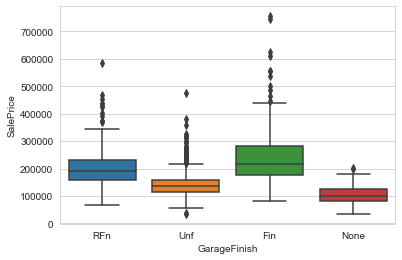

In [589]:
sns.boxplot(x = 'GarageFinish', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='GarageQual', ylabel='SalePrice'>

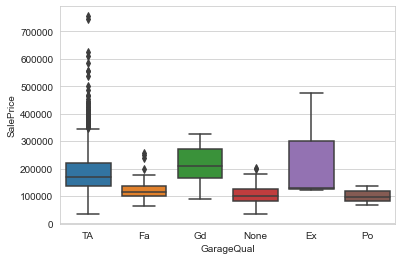

In [590]:
sns.boxplot(x = 'GarageQual', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='GarageCond', ylabel='SalePrice'>

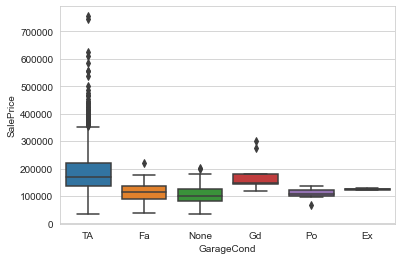

In [591]:
sns.boxplot(x = 'GarageCond', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='PoolQC', ylabel='SalePrice'>

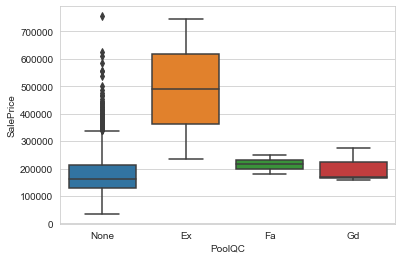

In [592]:
sns.boxplot(x = 'PoolQC', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='Fence', ylabel='SalePrice'>

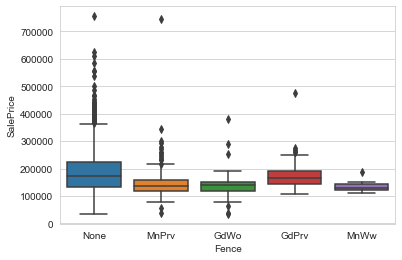

In [593]:
sns.boxplot(x = 'Fence', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='MiscFeature', ylabel='SalePrice'>

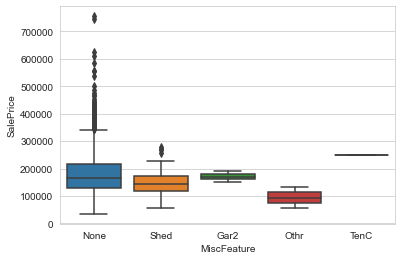

In [594]:
sns.boxplot(x = 'MiscFeature', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='SaleType', ylabel='SalePrice'>

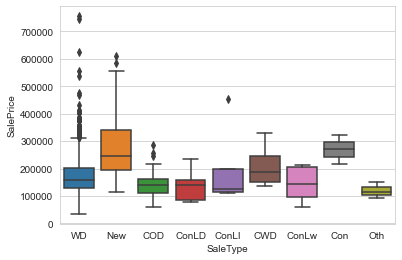

In [595]:
sns.boxplot(x = 'SaleType', y = 'SalePrice', data = dfTrainC)

<AxesSubplot:xlabel='SaleCondition', ylabel='SalePrice'>

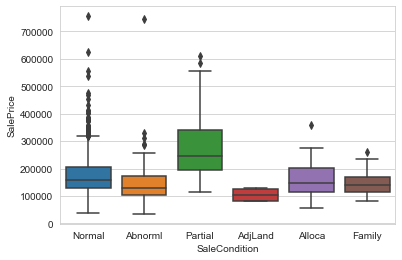

In [596]:
sns.boxplot(x = 'SaleCondition', y = 'SalePrice', data = dfTrainC)

In [597]:
##### Create Dummy Variables for categorical items
### you guys can probably replace with a loop
dfMSZoning = pd.get_dummies(dfBoth['MSZoning'],prefix='MSZoning')
dfStreet = pd.get_dummies(dfBoth['Street'],prefix='Street')
dfAlley = pd.get_dummies(dfBoth['Alley'],prefix='Alley')
dfLotShape = pd.get_dummies(dfBoth['LotShape'],prefix='LotShape')
dfLandContour = pd.get_dummies(dfBoth['LandContour'],prefix='LandContour')
dfUtilities = pd.get_dummies(dfBoth['Utilities'],prefix='Utilities')
dfLotConfig = pd.get_dummies(dfBoth['LotConfig'],prefix='LotConfig')
dfLandSlope = pd.get_dummies(dfBoth['LandSlope'],prefix='LandSlope')
dfNeighborhood = pd.get_dummies(dfBoth['Neighborhood'],prefix='Neighborhood')
dfCondition1 = pd.get_dummies(dfBoth['Condition1'],prefix='Condition1')
dfCondition2 = pd.get_dummies(dfBoth['Condition2'],prefix='Condition2')
dfBldgType = pd.get_dummies(dfBoth['BldgType'],prefix='BldgType')
dfHouseStyle = pd.get_dummies(dfBoth['HouseStyle'],prefix='HouseStyle')
dfRoofStyle = pd.get_dummies(dfBoth['RoofStyle'],prefix='RoofStyle')
dfRoofMatl = pd.get_dummies(dfBoth['RoofMatl'],prefix='RoofMatl')
dfExterior1st = pd.get_dummies(dfBoth['Exterior1st'],prefix='Exterior1st')
dfExterior2nd = pd.get_dummies(dfBoth['Exterior2nd'],prefix='Exterior2nd')
dfMasVnrType = pd.get_dummies(dfBoth['MasVnrType'],prefix='MasVnrType')
dfExterQual = pd.get_dummies(dfBoth['ExterQual'],prefix='ExterQual')
dfExterCond = pd.get_dummies(dfBoth['ExterCond'],prefix='ExterCond')
dfFoundation = pd.get_dummies(dfBoth['Foundation'],prefix='Foundation')
dfBsmtQual = pd.get_dummies(dfBoth['BsmtQual'],prefix='BsmtQual')
dfBsmtCond = pd.get_dummies(dfBoth['BsmtCond'],prefix='BsmtCond')
dfBsmtExposure = pd.get_dummies(dfBoth['BsmtExposure'],prefix='BsmtExposure')
dfBsmtFinType1 = pd.get_dummies(dfBoth['BsmtFinType1'],prefix='BsmtFinType1')
dfBsmtFinType2 = pd.get_dummies(dfBoth['BsmtFinType2'],prefix='BsmtFinType2')
dfHeating = pd.get_dummies(dfBoth['Heating'],prefix='Heating')
dfHeatingQC = pd.get_dummies(dfBoth['HeatingQC'],prefix='HeatingQC')
dfCentralAir = pd.get_dummies(dfBoth['CentralAir'],prefix='CentralAir')
dfElectrical = pd.get_dummies(dfBoth['Electrical'],prefix='Electrical')
dfKitchenQual = pd.get_dummies(dfBoth['KitchenQual'],prefix='KitchenQual')
dfFunctional = pd.get_dummies(dfBoth['Functional'],prefix='Functional')
dfFireplaceQu = pd.get_dummies(dfBoth['FireplaceQu'],prefix='FireplaceQu')
dfGarageType = pd.get_dummies(dfBoth['GarageType'],prefix='GarageType')
dfGarageFinish = pd.get_dummies(dfBoth['GarageFinish'],prefix='GarageFinish')
dfGarageQual = pd.get_dummies(dfBoth['GarageQual'],prefix='GarageQual')
dfGarageCond = pd.get_dummies(dfBoth['GarageCond'],prefix='GarageCond')
dfPoolQC = pd.get_dummies(dfBoth['PoolQC'],prefix='PoolQC')
dfFence = pd.get_dummies(dfBoth['Fence'],prefix='Fence')
dfMiscFeature = pd.get_dummies(dfBoth['MiscFeature'],prefix='MiscFeature')
dfSaleType = pd.get_dummies(dfBoth['SaleType'],prefix='SaleType')
dfSaleCondition = pd.get_dummies(dfBoth['SaleCondition'],prefix='SaleCondition')


##### Create Dummy Variables for categorical items
### you guys can probably replace with a loop
dfMSZoning = pd.get_dummies(dfBoth['MSZoning'])
dfStreet = pd.get_dummies(dfBoth['Street'])
dfAlley = pd.get_dummies(dfBoth['Alley'])
dfLotShape = pd.get_dummies(dfBoth['LotShape'])
dfLandContour = pd.get_dummies(dfBoth['LandContour'])
dfUtilities = pd.get_dummies(dfBoth['Utilities'])
dfLotConfig = pd.get_dummies(dfBoth['LotConfig'])
dfLandSlope = pd.get_dummies(dfBoth['LandSlope'])
dfNeighborhood = pd.get_dummies(dfBoth['Neighborhood'])
dfCondition1 = pd.get_dummies(dfBoth['Condition1'])
dfCondition2 = pd.get_dummies(dfBoth['Condition2'])
dfBldgType = pd.get_dummies(dfBoth['BldgType'])
dfHouseStyle = pd.get_dummies(dfBoth['HouseStyle'])
dfRoofStyle = pd.get_dummies(dfBoth['RoofStyle'])
dfRoofMatl = pd.get_dummies(dfBoth['RoofMatl'])
dfExterior1st = pd.get_dummies(dfBoth['Exterior1st'])
dfExterior2nd = pd.get_dummies(dfBoth['Exterior2nd'])
dfMasVnrType = pd.get_dummies(dfBoth['MasVnrType'])
dfExterQual = pd.get_dummies(dfBoth['ExterQual'])
dfExterCond = pd.get_dummies(dfBoth['ExterCond'])
dfFoundation = pd.get_dummies(dfBoth['Foundation'])
dfBsmtQual = pd.get_dummies(dfBoth['BsmtQual'])
dfBsmtCond = pd.get_dummies(dfBoth['BsmtCond'])
dfBsmtExposure = pd.get_dummies(dfBoth['BsmtExposure'])
dfBsmtFinType1 = pd.get_dummies(dfBoth['BsmtFinType1'])
dfBsmtFinType2 = pd.get_dummies(dfBoth['BsmtFinType2'])
dfHeating = pd.get_dummies(dfBoth['Heating'])
dfHeatingQC = pd.get_dummies(dfBoth['HeatingQC'])
dfCentralAir = pd.get_dummies(dfBoth['CentralAir'])
dfElectrical = pd.get_dummies(dfBoth['Electrical'])
dfKitchenQual = pd.get_dummies(dfBoth['KitchenQual'])
dfFunctional = pd.get_dummies(dfBoth['Functional'])
dfFireplaceQu = pd.get_dummies(dfBoth['FireplaceQu'])
dfGarageType = pd.get_dummies(dfBoth['GarageType'])
dfGarageFinish = pd.get_dummies(dfBoth['GarageFinish'])
dfGarageQual = pd.get_dummies(dfBoth['GarageQual'])
dfGarageCond = pd.get_dummies(dfBoth['GarageCond'])
dfPoolQC = pd.get_dummies(dfBoth['PoolQC'])
dfFence = pd.get_dummies(dfBoth['Fence'])
dfMiscFeature = pd.get_dummies(dfBoth['MiscFeature'])
dfSaleType = pd.get_dummies(dfBoth['SaleType'])
dfSaleCondition = pd.get_dummies(dfBoth['SaleCondition'])


In [598]:
# Add dummy variables into dataframe
dfBoth = pd.concat([dfBoth,dfMSZoning,dfStreet,dfAlley,dfLotShape,dfLandContour,dfUtilities,dfLotConfig,dfLandSlope,dfNeighborhood,dfCondition1,dfCondition2,dfBldgType,dfHouseStyle,dfRoofStyle,dfRoofMatl,dfExterior1st,dfExterior2nd,dfMasVnrType,dfExterQual,dfExterCond,dfFoundation,dfBsmtQual,dfBsmtCond,dfBsmtExposure,dfBsmtFinType1,dfBsmtFinType2,dfHeating,dfHeatingQC,dfCentralAir,dfElectrical,dfKitchenQual,dfFunctional,dfFireplaceQu,dfGarageType,dfGarageFinish,dfGarageQual,dfGarageCond,dfPoolQC,dfFence,dfMiscFeature,dfSaleType,dfSaleCondition
], axis=1)
dfBoth.head(5)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
dataSet index                                                               
train   0       1          60       RL         65.0     8450   Pave  None   
        1       2          20       RL         80.0     9600   Pave  None   
        2       3          60       RL         68.0    11250   Pave  None   
        3       4          70       RL         60.0     9550   Pave  None   
        4       5          60       RL         84.0    14260   Pave  None   

              LotShape LandContour Utilities  ... SaleType_ConLw SaleType_New  \
dataSet index                                 ...                               
train   0          Reg         Lvl    AllPub  ...              0            0   
        1          Reg         Lvl    AllPub  ...              0            0   
        2          IR1         Lvl    AllPub  ...              0            0   
        3          IR1         Lvl    AllPub  ...              0            0   
        4          IR1         Lvl    AllPub  ...              0            0   

              SaleType_Oth SaleType_WD SaleCondition_Abnorml  \
dataSet index                                                  
train   0                0           1                     0   
        1                0           1                     0   
        2                0           1                     0   
        3                0           1                     1   
        4                0           1                     0   

              SaleCondition_AdjLand SaleCondition_Alloca  \
dataSet index                                              
train   0                         0                    0   
        1                         0                    0   
        2                         0                    0   
        3                         0                    0   
        4                         0                    0   

               SaleCondition_Family  SaleCondition_Normal  \
dataSet index                                               
train   0                         0                     1   
        1                         0                     1   
        2                         0                     1   
        3                         0                     0   
        4                         0                     1   

               SaleCondition_Partial  
dataSet index                         
train   0                          0  
        1                          0  
        2                          0  
        3                          0  
        4                          0  

[5 rows x 344 columns]

### Data Analysis

In [599]:
# Again, separating data so I am only analyzing the training data which contains sale price
dfAnalysis = dfBoth.loc[dfBoth['SalePrice'] != '0']
dfSP = pd.to_numeric(dfAnalysis['SalePrice'])
dfAnalysis = pd.concat([dfAnalysis,dfSP], axis=1)
dfAnalysis.to_csv('dfAnalysis.csv',index=False)

In [600]:
# Correlation Matrix (Text table)
print("Correlation Matrix")
dfCorr = dfAnalysis.corr()
dfCorr.to_csv('dfCorr.csv',index=True)
dfCorr

Correlation Matrix


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,1.000000,0.011156,-0.009828,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050212,-0.005024,...,-0.018998,0.038920,0.026133,0.007009,-0.034852,-0.009018,0.004865,0.015881,-0.020738,-0.021917
MSSubClass,0.011156,1.000000,-0.356828,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022905,-0.069836,...,-0.045156,-0.014555,0.026359,0.005003,0.016241,0.030002,0.000983,0.024359,-0.051068,-0.084284
LotFrontage,-0.009828,-0.356828,1.000000,0.305194,0.234641,-0.053148,0.116955,0.083176,0.179112,0.214800,...,0.128296,-0.023187,-0.091303,-0.021761,-0.036702,-0.018055,0.016125,-0.073545,0.126584,0.334820
LotArea,-0.033226,-0.139781,0.305194,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103952,0.214103,...,0.020039,-0.005722,-0.002292,-0.029126,-0.013208,0.008966,-0.010781,0.005711,0.022635,0.263843
OverallQual,-0.028365,0.032628,0.234641,0.105806,1.000000,-0.091932,0.572323,0.550684,0.410200,0.239666,...,0.327412,-0.057962,-0.225013,-0.103535,-0.041677,-0.044950,-0.025515,-0.143282,0.323295,0.790982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleCondition_Alloca,-0.009018,0.030002,-0.018055,0.008966,-0.044950,-0.033444,-0.010104,-0.020727,-0.009747,0.021369,...,-0.027489,-0.004131,0.035530,-0.024817,-0.004772,1.000000,-0.010729,-0.194663,-0.027856,-0.015525
SaleCondition_Family,0.004865,0.000983,0.016125,-0.010781,-0.025515,-0.023873,-0.035785,-0.048056,-0.009909,0.000765,...,-0.035587,-0.005348,0.028599,-0.032128,-0.006177,-0.010729,1.000000,-0.252006,-0.036062,-0.046480
SaleCondition_Normal,0.015881,0.024359,-0.073545,0.005711,-0.143282,0.161642,-0.158427,-0.120577,-0.084204,-0.019560,...,-0.645698,-0.097031,0.634322,-0.582947,-0.112080,-0.194663,-0.252006,1.000000,-0.654323,-0.153990
SaleCondition_Partial,-0.020738,-0.051068,0.126584,0.022635,0.323295,-0.151659,0.343895,0.322837,0.165559,0.044912,...,0.986819,-0.013885,-0.769559,-0.083419,-0.016038,-0.027856,-0.036062,-0.654323,1.000000,0.352060


Results of correlation analysis show that the following attributes correlate to the saleprice of a home
* ExterQual_TA	-0.589043523
* KitchenQual_TA	-0.519297854
* Foundation_PConc	0.497733753
* KitchenQual_Ex	0.504093676
* YearRemodAdd	0.507100967
* YearBuilt	0.522897333
* TotRmsAbvGrd	0.533723156
* BsmtQual_Ex	0.553104847
* FullBath	0.560663763
* 1stFlrSF	0.605852185
* TotalBsmtSF	0.613580552
* GarageArea	0.623431439
* GarageCars	0.640409197
* GrLivArea	0.708624478
* OverallQual	0.790981601

In [605]:
# I will now filter the data to only contain these variables
dfBoth = dfBoth[["SalePrice","ExterQual_TA","KitchenQual_TA","Foundation_PConc","KitchenQual_Ex","YearRemodAdd","YearBuilt","TotRmsAbvGrd","BsmtQual_Ex","FullBath","1stFlrSF","TotalBsmtSF","GarageArea","GarageCars","GrLivArea","OverallQual"]]
dfBoth.head(5)

SalePrice  ExterQual_TA  KitchenQual_TA  Foundation_PConc  \
dataSet index                                                             
train   0      208500.0             0               0                 1   
        1      181500.0             1               1                 0   
        2      223500.0             0               0                 1   
        3      140000.0             1               0                 0   
        4      250000.0             0               0                 1   

               KitchenQual_Ex  YearRemodAdd  YearBuilt  TotRmsAbvGrd  \
dataSet index                                                          
train   0                   0          2003       2003             8   
        1                   0          1976       1976             6   
        2                   0          2002       2001             6   
        3                   0          1970       1915             7   
        4                   0          2000       2000             9   

               BsmtQual_Ex  FullBath  1stFlrSF  TotalBsmtSF  GarageArea  \
dataSet index                                                             
train   0                0         2       856        856.0       548.0   
        1                0         2      1262       1262.0       460.0   
        2                0         2       920        920.0       608.0   
        3                0         1       961        756.0       642.0   
        4                0         2      1145       1145.0       836.0   

               GarageCars  GrLivArea  OverallQual  
dataSet index                                      
train   0             2.0       1710            7  
        1             2.0       1262            6  
        2             2.0       1786            7  
        3             3.0       1717            7  
        4             3.0       2198            8

In [608]:
# Again, separating data so I am only analyzing the training data which contains sale price
dfAnalysis = dfBoth.loc[dfBoth['SalePrice'] != '0']
dfSP = pd.to_numeric(dfAnalysis['SalePrice'])
dfAnalysis = pd.concat([dfAnalysis,dfSP], axis=1)

Histograms: All variables


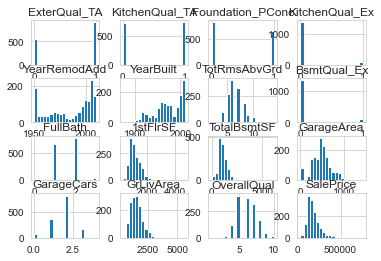

In [611]:
print("Histograms: All variables")
hist = dfAnalysis.hist(bins=20)
